In [1]:
import pandas as pd
import dfhelper as dh
from app import MlProject

In [2]:
file = 'data/Employee-Attrition.csv'
df = pd.read_csv(file)

In [3]:
def ordered_concat(new_dfs, orig_df):
    new_df = pd.concat(new_dfs, axis=1)
    new_df = new_df[df.columns]  # Reorder columns to match original DataFrame

    return new_df

In [4]:
from sklearn.impute import SimpleImputer

def impute_missing_vals(input_df, proj: MlProject = None):
    df = input_df.copy()
    num_imputer = SimpleImputer(strategy='mean')
    # cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
    
    df_num = df.select_dtypes(include=['float64', 'int64'])
    # df_num = df[[c for c in df.columns if not proj.columns[c].isDiscrete()]]
    df_cat = df.select_dtypes(include=['object'])
    # df_cat = df[[c for c in df.columns if proj.columns[c].isDiscrete()]]
    
    df_num_imputed = pd.DataFrame(num_imputer.fit_transform(df_num), columns=df_num.columns)
    df_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(df_cat), columns=df_cat.columns)
    
    #return ordered_concat([df_num_imputed, df_cat_imputed], df)
    df.update(df_num_imputed)
    df.update(df_cat_imputed)
    return df

imputed_df = impute_missing_vals(df)

In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

def remove_invariants(input_df, proj: MlProject = None, threshold=0.0):
    df = input_df.copy()
    # target = proj.targetVariable
    target = 'Attrition'

    target_column = df[target]
    feature_columns = df.drop(columns=[target])
    for column in [c for c in feature_columns.columns if feature_columns[c].dtype == 'object']:
            le = LabelEncoder()
            feature_columns[column] = le.fit_transform(feature_columns[column])

    selector = VarianceThreshold(threshold=threshold)
    selector.fit_transform(feature_columns)

    columns_kept = list(feature_columns.columns[selector.get_support()])
    to_drop = [c for c in feature_columns.columns if c not in columns_kept]
    df = df.drop(columns=to_drop)

    # df_reduced = pd.DataFrame(reduced_arr, columns=columns_kept, index=df.index)
    # df_reduced[target] = target_column
    # ordered_columns = [col for col in df.columns if col in df_reduced.columns]
    # df_reduced = df_reduced[ordered_columns]
    return df
print(imputed_df['Gender'])
no_invariant_df = remove_invariants(imputed_df)
print(no_invariant_df['Gender'])

0       Female
1         Male
2         Male
3       Female
4         Male
         ...  
1465      Male
1466      Male
1467      Male
1468      Male
1469      Male
Name: Gender, Length: 1470, dtype: object
0       Female
1         Male
2         Male
3       Female
4         Male
         ...  
1465      Male
1466      Male
1467      Male
1468      Male
1469      Male
Name: Gender, Length: 1470, dtype: object


In [6]:
import numpy as np
from scipy import stats

def handle_outliers(input_df, proj: MlProject = None):
    df = input_df.copy()
    # target = proj.targetVariable
    target = 'Attrition'

    df_num = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target], errors='ignore')
    # df_num = df[[c for c in df.columns if not proj.columns[c].isDiscrete() and c != target]]
    
    z_scores = np.abs(stats.zscore(df_num))
    for col in df_num.columns:
        df[col] = np.where(z_scores[col] > 3, df[col].median(), df[col])
    return df

no_outlier_df = handle_outliers(no_invariant_df)

In [7]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor


def remove_lin_dep(input_df, proj: MlProject = None, vif_thresh=5):
    df = input_df.copy()
    # target = proj.targetVariable
    target = 'Attrition'

    feature_columns = df.drop(columns=[target])
    for column in [c for c in feature_columns.columns if feature_columns[c].dtype == 'object']:
            le = LabelEncoder()
            feature_columns[column] = le.fit_transform(feature_columns[column])

    vif_data = pd.DataFrame({'feature':feature_columns.columns,
                             'VIF':[variance_inflation_factor(feature_columns.values, i) for i in range(len(feature_columns.columns))]})

    to_drop = vif_data[vif_data['VIF'] > 5]['feature']
    df = df.drop(columns=to_drop)
    return df
print(no_outlier_df['Gender'])
no_lin_dep = remove_lin_dep(no_outlier_df)
print(no_lin_dep)

0       Female
1         Male
2         Male
3       Female
4         Male
         ...  
1465      Male
1466      Male
1467      Male
1468      Male
1469      Male
Name: Gender, Length: 1470, dtype: object
     Attrition  DailyRate  DistanceFromHome EducationField  EmployeeNumber  \
0          Yes     1102.0               1.0  Life Sciences             1.0   
1           No      279.0               8.0  Life Sciences             2.0   
2          Yes     1373.0               2.0          Other             4.0   
3           No     1392.0               3.0  Life Sciences             5.0   
4           No      591.0               2.0        Medical             7.0   
...        ...        ...               ...            ...             ...   
1465        No      884.0              23.0        Medical          2061.0   
1466        No      613.0               6.0        Medical          2062.0   
1467        No      155.0               4.0  Life Sciences          2064.0   
1468        N

In [8]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def encode_vars(input_df, proj: MlProject = None, onehot=True):
    df = input_df.copy()
    # target = proj.targetVariable
    target = 'Attrition'
    if df[target].dtype == 'object':
        le = LabelEncoder()
        df[target] = le.fit_transform(df[target])

    df_cat = df.select_dtypes(include=['object']).drop(columns=[target], errors='ignore')
    # df_cat = df[[c for c in df.columns if proj.columns[c].isDiscrete() and c != target]]
    if onehot:
        df = pd.get_dummies(df, columns=df_cat.columns, drop_first=True)
    else:
        for column in df_cat.columns:
            le = LabelEncoder()
            df[column] = le.fit_transform(df_cat[column])
    return df

encoded_df = encode_vars(imputed_df)

In [9]:
file = 'data/Employee-Attrition.csv'
df = pd.read_csv(file)
params = {'impute':True, 'remove_invariants':True, 'handle_outliers':True, 'vif_threshold':5, 'encoding':'onehot'}

def pre_process(df, params=None, proj: MlProject = None):
    if params is None:
        params = {'impute':True, 'remove_invariants':True, 'handle_outliers':True, 'vif_threshold':5, 'encoding':'onehot'}

    if params['impute']:
        df = impute_missing_vals(df, proj)
    
    if params['remove_invariants']:
        df = remove_invariants(df, proj)

    if params['handle_outliers']:
        df = handle_outliers(df, proj)
    
    if params['vif_threshold'] > 0:
        df = remove_lin_dep(df, proj, vif_thresh=params['vif_threshold'])

    encoded_df = encode_vars(df, proj, onehot=(params['encoding'] == 'onehot'))
    return encoded_df, df

enc_df, _ = pre_process(df,params)

Training and evaluating model: Nearest Neighbors
Accuracy: 0.8095
F1 Score: 0.7878
ROC AUC: 0.5372
Cross-validated Accuracy: 0.7662


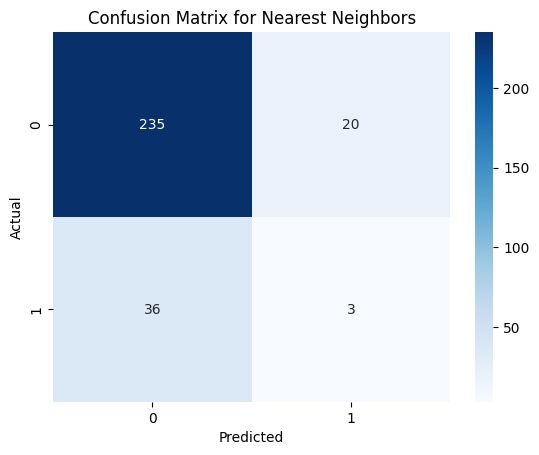

Permutation Importances:
                            feature  importance
4                  StockOptionLevel    0.000000
3                NumCompaniesWorked    0.000000
8            EducationField_Medical    0.000000
7          EducationField_Marketing    0.000000
6      EducationField_Life Sciences    0.000000
11                      Gender_Male    0.000000
10  EducationField_Technical Degree    0.000000
12                     OverTime_Yes    0.000000
9              EducationField_Other    0.000000
5           YearsSinceLastPromotion   -0.003401
1                  DistanceFromHome   -0.004082
0                         DailyRate   -0.008503
2                    EmployeeNumber   -0.015646


Training and evaluating model: Linear SVM


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             mean_absolute_error, mean_squared_error, r2_score,
                             confusion_matrix)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

target = 'Attrition'
X = enc_df.drop(columns=[target])
y = enc_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers and regressors
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", C=0.025, probability=True, random_state=42),
    "RBF SVM": SVC(gamma=2, C=1, probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(
        penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=42
    ),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME", random_state=42),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
}

regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Gaussian Process Regression": GaussianProcessRegressor(1.0 * RBF(1.0)),
    "Decision Tree Regression": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest Regression": RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=42
    ),
    "Neural Net Regression": MLPRegressor(
        hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001, random_state=42
    ),
    "AdaBoost Regression": AdaBoostRegressor(
        n_estimators=50, learning_rate=1.0, random_state=42
    ),
    "K Neighbors Regression": KNeighborsRegressor(n_neighbors=5),
}

# Determine whether the task is classification or regression
if y.dtype == 'object' or len(y.unique()) < 20:  # Adjust this threshold as needed
    task_type = 'classification'
    models = classifiers
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
        "ROC AUC": lambda y_true, y_pred: roc_auc_score(y_true, y_pred, multi_class='ovo')
    }
    scoring = 'accuracy'  # Scoring for cross-validation in classification
else:
    task_type = 'regression'
    models = regressors
    metrics = {
        "Mean Absolute Error": mean_absolute_error,
        "Mean Squared Error": mean_squared_error,
        "Root Mean Squared Error": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        "R-squared": r2_score
    }
    scoring = 'neg_mean_squared_error'  # Scoring for cross-validation in regression

# Evaluate all models
for name, model in models.items():
    print(f"Training and evaluating model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model with all relevant metrics
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC" and task_type == 'classification' and len(y.unique()) == 2:
            score = metric_func(y_test, model.predict_proba(X_test)[:, 1])
        else:
            score = metric_func(y_test, y_pred)
        print(f"{metric_name}: {score:.4f}")

    # Calculate and print cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    if task_type == 'classification':
        print(f"Cross-validated Accuracy: {cv_scores.mean():.4f}")
    else:
        print(f"Cross-validated RMSE: {np.sqrt(-cv_scores.mean()):.4f}")

    # Confusion matrix for classification
    if task_type == 'classification':
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {name}')
        plt.show()

    # Calculate and print permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean
    }).sort_values(by='importance', ascending=False)

    print("Permutation Importances:")
    print(perm_importance_df)
    print("\n")



In [39]:
discrete = (enc_df[target].dtype == 'object') #proj.columns[target].isDiscrete()


1097    0
727     0
254     0
1175    0
1341    0
       ..
1130    0
1294    0
860     1
1459    0
1126    0
Name: Attrition, Length: 1176, dtype: int64

In [10]:
import sys
import pandas as pd
import numpy as np
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget, QLabel, QScrollArea, QSizePolicy
from PyQt5.QtCore import Qt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             mean_absolute_error, mean_squared_error, r2_score,
                             confusion_matrix)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso

target = 'Attrition'
X = enc_df.drop(columns=[target])
y = enc_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers and regressors
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", C=0.025, probability=True, random_state=42),
    "RBF SVM": SVC(gamma=2, C=1, probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(
        penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=42
    ),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME", random_state=42),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
}

regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Gaussian Process Regression": GaussianProcessRegressor(1.0 * RBF(1.0)),
    "Decision Tree Regression": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest Regression": RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=42
    ),
    "Neural Net Regression": MLPRegressor(
        hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001, random_state=42
    ),
    "AdaBoost Regression": AdaBoostRegressor(
        n_estimators=50, learning_rate=1.0, random_state=42
    ),
    "K Neighbors Regression": KNeighborsRegressor(n_neighbors=5),
}

# Determine whether the task is classification or regression
if y.dtype == 'object' or len(y.unique()) < 20:  # Adjust this threshold as needed
    task_type = 'classification'
    models = classifiers
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
        "ROC AUC": lambda y_true, y_pred: roc_auc_score(y_true, y_pred, multi_class='ovo')
    }
    scoring = 'accuracy'  # Scoring for cross-validation in classification
else:
    task_type = 'regression'
    models = regressors
    metrics = {
        "Mean Absolute Error": mean_absolute_error,
        "Mean Squared Error": mean_squared_error,
        "Root Mean Squared Error": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        "R-squared": r2_score
    }
    scoring = 'neg_mean_squared_error'  # Scoring for cross-validation in regression

# Initialize results storage
results = []
perm_importance_dict = {}
confusion_matrices = {}

# Evaluate all models
for name, model in models.items():
    print(f"Training and evaluating model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    result = {"Model": name}
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC" and task_type == 'classification' and len(y.unique()) == 2:
            score = metric_func(y_test, model.predict_proba(X_test)[:, 1])
        else:
            score = metric_func(y_test, y_pred)
        result[metric_name] = score

    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    if task_type == 'classification':
        result["Cross-validated Accuracy"] = cv_scores.mean()
    else:
        result["Cross-validated RMSE"] = np.sqrt(-cv_scores.mean())

    results.append(result)

    # Confusion matrix for classification
    if task_type == 'classification':
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices[name] = cm

    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean
    })

    # Combine importances for one-hot encoded features
    original_features = {}
    for feature in perm_importance_df['feature']:
        base_feature = feature.split('_')[0]
        if base_feature in original_features:
            original_features[base_feature] += perm_importance_df.loc[perm_importance_df['feature'] == feature, 'importance'].values[0]
        else:
            original_features[base_feature] = perm_importance_df.loc[perm_importance_df['feature'] == feature, 'importance'].values[0]

    perm_importance_df_combined = pd.DataFrame(list(original_features.items()), columns=['feature', 'importance'])
    perm_importance_df_combined = perm_importance_df_combined.sort_values(by='importance', ascending=False)
    perm_importance_dict[name] = perm_importance_df_combined

# Convert results to a DataFrame and rank them by performance
results_df = pd.DataFrame(results)

if task_type == 'classification':
    best_model_idx = results_df['Accuracy'].idxmax()
    results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
else:
    best_model_idx = results_df['R-squared'].idxmax()
    results_df.sort_values(by="R-squared", ascending=False, inplace=True)

# PyQt5 application class
class ModelEvaluationApp(QMainWindow):
    def __init__(self):
        super().__init__()

        # Set the window properties
        self.setWindowTitle("Model Evaluation Results")
        self.setGeometry(100, 100, 1400, 900)

        # Create a main layout
        self.main_widget = QWidget(self)
        self.setCentralWidget(self.main_widget)
        self.main_layout = QVBoxLayout(self.main_widget)

        # Add methods section
        self.add_methods_section()

        # Add pipeline diagram
        self.add_pipeline_diagram()

        # Add results section
        self.add_results_section()

    def add_methods_section(self):
        methods_label = QLabel("Methods Used in the Process:")
        methods_label.setAlignment(Qt.AlignCenter)
        self.main_layout.addWidget(methods_label)

        methods_text = ("<b>Preprocessing:</b> This involves handling missing values, removing invariant features, handling outliers, "
                        "checking for multicollinearity using VIF, and encoding categorical variables using one-hot encoding.<br>"
                        "<b>Training:</b> A variety of classifiers and regressors are trained depending on the type of task (classification or regression).<br>"
                        "<b>Evaluation:</b> Models are evaluated using metrics such as accuracy, F1 score, and ROC AUC for classification, "
                        "and MAE, RMSE, and R-squared for regression. Cross-validation is used to ensure stability of the models.<br>"
                        "<b>Permutation Importance:</b> This assesses feature importances across models by evaluating the increase in error when a feature's values are randomly permuted.<br>"
                        "<b>Confusion Matrix:</b> Provides insight into the types of errors made by each classifier.")
        
        methods_display = QLabel(methods_text)
        methods_display.setAlignment(Qt.AlignLeft)
        methods_display.setWordWrap(True)
        methods_display.setStyleSheet("font-size: 10pt;")
        methods_scroll_area = QScrollArea(self)
        methods_scroll_area.setWidget(methods_display)
        methods_scroll_area.setWidgetResizable(True)
        methods_scroll_area.setFixedHeight(150)
        self.main_layout.addWidget(methods_scroll_area)

    def add_pipeline_diagram(self):
        pipeline_label = QLabel("Pipeline Diagram:")
        pipeline_label.setAlignment(Qt.AlignCenter)
        self.main_layout.addWidget(pipeline_label)

        # Create a flowchart of the pipeline using arrows
        pipeline_fig, ax = plt.subplots(figsize=(12, 2))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 1)

        stages = ['Data', 'Impute Missing Values', 'Remove Invariants', 
                  'Handle Outliers', 'VIF Check', 'Encoding', 'Training', 'Evaluation']

        x_pos = np.linspace(0.5, 9.5, len(stages))

        for i, stage in enumerate(stages):
            ax.text(x_pos[i], 0.5, stage, ha='center', va='center', fontsize=9, bbox=dict(facecolor='skyblue', alpha=0.5, edgecolor='blue'))
            if i < len(stages) - 1:
                ax.arrow(x_pos[i] + 0.35, 0.5, 0.7, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')

        ax.set_axis_off()
        plt.tight_layout()
        pipeline_canvas = FigureCanvas(pipeline_fig)
        pipeline_canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        self.main_layout.addWidget(pipeline_canvas)

    def add_results_section(self):
        results_label = QLabel("Model Evaluation Results:")
        results_label.setAlignment(Qt.AlignCenter)
        self.main_layout.addWidget(results_label)

        # Highlight the best model
        highlight_style = '<style> .highlight {background-color: yellow;} </style>'

        # Display the results DataFrame
        results_html = results_df.to_html(index=False).replace(
            '<tr>',
            f'<tr class="highlight">' if results_df.index[0] == best_model_idx else '<tr>',
            1
        )

        results_text = QLabel(highlight_style + results_html, self)
        results_text.setAlignment(Qt.AlignCenter)
        results_text.setOpenExternalLinks(True)
        results_text.setStyleSheet("font-size: 10pt;")
        results_scroll_area = QScrollArea(self)
        results_scroll_area.setWidget(results_text)
        results_scroll_area.setWidgetResizable(True)
        results_scroll_area.setFixedHeight(300)
        self.main_layout.addWidget(results_scroll_area)

        # Add permutation importance plots
        self.add_permutation_importance_plot()

        # Add confusion matrices if classification
        if task_type == 'classification':
            self.add_confusion_matrix_plot()

    def add_permutation_importance_plot(self):
        permutation_label = QLabel("Permutation Importance for All Models:")
        permutation_label.setAlignment(Qt.AlignCenter)
        self.main_layout.addWidget(permutation_label)

        # Create a figure with subplots for permutation importance of all models
        perm_fig, axes = plt.subplots(len(models), 1, figsize=(8, len(models) * 4), squeeze=False)
        
        for idx, (model_name, importance_df) in enumerate(perm_importance_dict.items()):
            sns.barplot(x='importance', y='feature', data=importance_df, ax=axes[idx, 0])
            axes[idx, 0].set_title(f'Permutation Importance for {model_name}')
            axes[idx, 0].set_xlabel('Importance')
            axes[idx, 0].set_ylabel('Feature')

        plt.tight_layout()
        perm_canvas = FigureCanvas(perm_fig)
        perm_canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        perm_scroll_area = QScrollArea(self)
        perm_scroll_area.setWidget(perm_canvas)
        perm_scroll_area.setWidgetResizable(True)
        perm_scroll_area.setFixedHeight(400)
        self.main_layout.addWidget(perm_scroll_area)

    def add_confusion_matrix_plot(self):
        confusion_label = QLabel("Confusion Matrices for All Models:")
        confusion_label.setAlignment(Qt.AlignCenter)
        self.main_layout.addWidget(confusion_label)

        # Create a figure with subplots for confusion matrices of all models
        cm_fig, axes = plt.subplots(len(confusion_matrices), 1, figsize=(8, len(confusion_matrices) * 4), squeeze=False)
        
        for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx, 0])
            axes[idx, 0].set_title(f'Confusion Matrix for {model_name}')
            axes[idx, 0].set_xlabel('Predicted')
            axes[idx, 0].set_ylabel('Actual')

        plt.tight_layout()
        cm_canvas = FigureCanvas(cm_fig)
        cm_canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        cm_scroll_area = QScrollArea(self)
        cm_scroll_area.setWidget(cm_canvas)
        cm_scroll_area.setWidgetResizable(True)
        cm_scroll_area.setFixedHeight(400)
        self.main_layout.addWidget(cm_scroll_area)

# Main execution
def main():
    app = QApplication(sys.argv)
    ex = ModelEvaluationApp()
    ex.show()
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()
# # Display the results
# print("\nConsolidated Results:")
# print(results_df)

# # Plotting the results
# if task_type == 'classification':
#     metric_to_plot = "Accuracy"
# else:
#     metric_to_plot = "R-squared"

# plt.figure(figsize=(10, 6))
# sns.barplot(x='Model', y=metric_to_plot, data=results_df)
# plt.xticks(rotation=45)
# plt.title(f'Model Comparison based on {metric_to_plot}')
# plt.xlabel('Model')
# plt.ylabel(metric_to_plot)
# plt.tight_layout()
# plt.show()

Training and evaluating model: Nearest Neighbors
Training and evaluating model: Linear SVM


In [10]:
import sys
import pandas as pd
import numpy as np
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget, QLabel, QScrollArea, QSizePolicy
from PyQt5.QtCore import Qt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             mean_absolute_error, mean_squared_error, r2_score,
                             confusion_matrix)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso

target = 'Attrition'
X = enc_df.drop(columns=[target])
y = enc_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers and regressors
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", C=0.025, probability=True, random_state=42),
    "RBF SVM": SVC(gamma=2, C=1, probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(
        penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=42
    ),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME", random_state=42),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
}

regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Gaussian Process Regression": GaussianProcessRegressor(1.0 * RBF(1.0)),
    "Decision Tree Regression": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest Regression": RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=42
    ),
    "Neural Net Regression": MLPRegressor(
        hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001, random_state=42
    ),
    "AdaBoost Regression": AdaBoostRegressor(
        n_estimators=50, learning_rate=1.0, random_state=42
    ),
    "K Neighbors Regression": KNeighborsRegressor(n_neighbors=5),
}

# Determine whether the task is classification or regression
if y.dtype == 'object' or len(y.unique()) < 20:  # Adjust this threshold as needed
    task_type = 'classification'
    models = classifiers
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
        "ROC AUC": lambda y_true, y_pred: roc_auc_score(y_true, y_pred, multi_class='ovo')
    }
    scoring = 'accuracy'  # Scoring for cross-validation in classification
else:
    task_type = 'regression'
    models = regressors
    metrics = {
        "Mean Absolute Error": mean_absolute_error,
        "Mean Squared Error": mean_squared_error,
        "Root Mean Squared Error": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        "R-squared": r2_score
    }
    scoring = 'neg_mean_squared_error'  # Scoring for cross-validation in regression

# Initialize results storage
results = []
perm_importance_dict = {}
confusion_matrices = {}

# Evaluate all models
for name, model in models.items():
    print(f"Training and evaluating model: {name}")
    model = make_pipeline(StandardScaler(), model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    result = {"Model": name}
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC" and task_type == 'classification' and len(y.unique()) == 2:
            score = metric_func(y_test, model.predict_proba(X_test)[:, 1])
        else:
            score = metric_func(y_test, y_pred)
        result[metric_name] = score

    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    if task_type == 'classification':
        result["Cross-validated Accuracy"] = cv_scores.mean()
    else:
        result["Cross-validated RMSE"] = np.sqrt(-cv_scores.mean())

    results.append(result)

    # Confusion matrix for classification
    if task_type == 'classification':
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices[name] = cm

    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean
    })

    # Combine importances for one-hot encoded features
    original_features = {}
    for feature in perm_importance_df['feature']:
        base_feature = feature.split('_')[0]
        if base_feature in original_features:
            original_features[base_feature] += perm_importance_df.loc[perm_importance_df['feature'] == feature, 'importance'].values[0]
        else:
            original_features[base_feature] = perm_importance_df.loc[perm_importance_df['feature'] == feature, 'importance'].values[0]

    perm_importance_df_combined = pd.DataFrame(list(original_features.items()), columns=['feature', 'importance'])
    perm_importance_df_combined = perm_importance_df_combined.sort_values(by='importance', ascending=False)
    perm_importance_dict[name] = perm_importance_df_combined

# Convert results to a DataFrame and rank them by performance
results_df = pd.DataFrame(results)

if task_type == 'classification':
    best_model_idx = results_df['Accuracy'].idxmax()
    results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
else:
    best_model_idx = results_df['R-squared'].idxmax()
    results_df.sort_values(by="R-squared", ascending=False, inplace=True)

# # PyQt5 application class
# class ModelEvaluationApp(QMainWindow):
#     def __init__(self):
#         super().__init__()

#         # Set the window properties
#         self.setWindowTitle("Model Evaluation Results")
#         self.setGeometry(100, 100, 1400, 900)

#         # Create a main layout
#         self.main_widget = QWidget(self)
#         self.setCentralWidget(self.main_widget)
#         self.main_layout = QVBoxLayout(self.main_widget)

#         # Add methods section
#         self.add_methods_section()

#         # Add pipeline diagram
#         self.add_pipeline_diagram()

#         # Add results section
#         self.add_results_section()

#     def add_methods_section(self):
#         methods_label = QLabel("Methods Used in the Process:")
#         methods_label.setAlignment(Qt.AlignCenter)
#         self.main_layout.addWidget(methods_label)

#         methods_text = ("<b>Preprocessing:</b> This involves handling missing values, removing invariant features, handling outliers, "
#                         "checking for multicollinearity using VIF, and encoding categorical variables using one-hot encoding.<br>"
#                         "<b>Training:</b> A variety of classifiers and regressors are trained depending on the type of task (classification or regression).<br>"
#                         "<b>Evaluation:</b> Models are evaluated using metrics such as accuracy, F1 score, and ROC AUC for classification, "
#                         "and MAE, RMSE, and R-squared for regression. Cross-validation is used to ensure stability of the models.<br>"
#                         "<b>Permutation Importance:</b> This assesses feature importances across models by evaluating the increase in error when a feature's values are randomly permuted.<br>"
#                         "<b>Confusion Matrix:</b> Provides insight into the types of errors made by each classifier.")
        
#         methods_display = QLabel(methods_text)
#         methods_display.setAlignment(Qt.AlignLeft)
#         methods_display.setWordWrap(True)
#         methods_display.setStyleSheet("font-size: 10pt;")
#         methods_scroll_area = QScrollArea(self)
#         methods_scroll_area.setWidget(methods_display)
#         methods_scroll_area.setWidgetResizable(True)
#         methods_scroll_area.setFixedHeight(150)
#         self.main_layout.addWidget(methods_scroll_area)

#     def add_pipeline_diagram(self):
#         pipeline_label = QLabel("Pipeline Diagram:")
#         pipeline_label.setAlignment(Qt.AlignCenter)
#         self.main_layout.addWidget(pipeline_label)

#         # Create a flowchart of the pipeline using arrows
#         pipeline_fig, ax = plt.subplots(figsize=(12, 2))
#         ax.set_xlim(0, 10)
#         ax.set_ylim(0, 1)

#         stages = ['Data', 'Impute Missing Values', 'Remove Invariants', 
#                   'Handle Outliers', 'VIF Check', 'Encoding', 'Training', 'Evaluation']

#         x_pos = np.linspace(0.5, 9.5, len(stages))

#         for i, stage in enumerate(stages):
#             ax.text(x_pos[i], 0.5, stage, ha='center', va='center', fontsize=9, bbox=dict(facecolor='skyblue', alpha=0.5, edgecolor='blue'))
#             if i < len(stages) - 1:
#                 ax.arrow(x_pos[i] + 0.35, 0.5, 0.7, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')

#         ax.set_axis_off()
#         plt.tight_layout()
#         pipeline_canvas = FigureCanvas(pipeline_fig)
#         pipeline_canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)
#         pipeline_canvas.setFixedHeight(200)
#         self.main_layout.addWidget(pipeline_canvas)

#     def add_results_section(self):
#         results_label = QLabel("Model Evaluation Results:")
#         results_label.setAlignment(Qt.AlignCenter)
#         self.main_layout.addWidget(results_label)

#         # Highlight the best model
#         highlight_style = '<style> .highlight {background-color: yellow;} </style>'

#         # Display the results DataFrame
#         results_html = results_df.to_html(index=False).replace(
#             '<tr>',
#             f'<tr class="highlight">' if results_df.index[0] == best_model_idx else '<tr>',
#             1
#         )

#         results_text = QLabel(highlight_style + results_html, self)
#         results_text.setAlignment(Qt.AlignCenter)
#         results_text.setOpenExternalLinks(True)
#         results_text.setStyleSheet("font-size: 10pt;")
#         results_scroll_area = QScrollArea(self)
#         results_scroll_area.setWidget(results_text)
#         results_scroll_area.setWidgetResizable(True)
#         results_scroll_area.setFixedHeight(300)
#         self.main_layout.addWidget(results_scroll_area)

#         # Add permutation importance plots
#         self.add_permutation_importance_plot()

#         # Add confusion matrices if classification
#         if task_type == 'classification':
#             self.add_confusion_matrix_plot()

#     def add_permutation_importance_plot(self):
#         permutation_label = QLabel("Permutation Importance for All Models:")
#         permutation_label.setAlignment(Qt.AlignCenter)
#         self.main_layout.addWidget(permutation_label)

#         # Create a figure with subplots for permutation importance of all models
#         perm_fig, axes = plt.subplots(len(models), 1, figsize=(8, len(models) * 4), squeeze=False)
        
#         for idx, (model_name, importance_df) in enumerate(perm_importance_dict.items()):
#             sns.barplot(x='importance', y='feature', data=importance_df, ax=axes[idx, 0])
#             axes[idx, 0].set_title(f'Permutation Importance for {model_name}')
#             axes[idx, 0].set_xlabel('Importance')
#             axes[idx, 0].set_ylabel('Feature')

#         plt.tight_layout()
#         perm_canvas = FigureCanvas(perm_fig)
#         perm_canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
#         perm_scroll_area = QScrollArea(self)
#         perm_scroll_area.setWidget(perm_canvas)
#         perm_scroll_area.setWidgetResizable(True)
#         perm_scroll_area.setFixedHeight(400)
#         self.main_layout.addWidget(perm_scroll_area)

#     def add_confusion_matrix_plot(self):
#         confusion_label = QLabel("Confusion Matrices for All Models:")
#         confusion_label.setAlignment(Qt.AlignCenter)
#         self.main_layout.addWidget(confusion_label)

#         # Create a figure with subplots for confusion matrices of all models
#         cm_fig, axes = plt.subplots(len(confusion_matrices), 1, figsize=(8, len(confusion_matrices) * 4), squeeze=False)
        
#         for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
#             sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx, 0])
#             axes[idx, 0].set_title(f'Confusion Matrix for {model_name}')
#             axes[idx, 0].set_xlabel('Predicted')
#             axes[idx, 0].set_ylabel('Actual')

#         plt.tight_layout()
#         cm_canvas = FigureCanvas(cm_fig)
#         cm_canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
#         cm_scroll_area = QScrollArea(self)
#         cm_scroll_area.setWidget(cm_canvas)
#         cm_scroll_area.setWidgetResizable(True)
#         cm_scroll_area.setFixedHeight(400)
#         self.main_layout.addWidget(cm_scroll_area)

# # Main execution
# def main():
#     app = QApplication(sys.argv)
#     ex = ModelEvaluationApp()
#     ex.show()
#     sys.exit(app.exec_())

# if __name__ == '__main__':
#     main()


Training and evaluating model: Nearest Neighbors
Training and evaluating model: Linear SVM
Training and evaluating model: RBF SVM
Training and evaluating model: Logistic Regression
Training and evaluating model: Gaussian Process
Training and evaluating model: Decision Tree
Training and evaluating model: Random Forest
Training and evaluating model: Neural Net
Training and evaluating model: AdaBoost
Training and evaluating model: Naive Bayes
Training and evaluating model: QDA


In [1]:
from PyQt5.QtWidgets import QMainWindow, QWidget, QVBoxLayout, QSplitter, QScrollArea, QGroupBox, QLabel
from PyQt5.QtCore import Qt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import numpy as np
import seaborn as sns
import pandas as pd

class ModelEvaluationApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Model Evaluation Results")
        self.setGeometry(100, 100, 800, 600)

        # Create main widget and layout
        main_widget = QWidget()
        main_layout = QVBoxLayout(main_widget)

        # Create vertical splitter for the first 3 sub-windows
        vertical_splitter = QSplitter(Qt.Vertical)
        sub_window_heights = [200, 100, 300]  # Ratios 2:1:3 for the top three windows

        # Add sub-windows with content from ModelEvaluationApp
        vertical_splitter.addWidget(self.create_methods_subwindow())
        vertical_splitter.addWidget(self.create_pipeline_subwindow())
        vertical_splitter.addWidget(self.create_results_subwindow())

        # Set initial sizes of the three vertical windows
        vertical_splitter.setSizes(sub_window_heights)

        # Create horizontal splitter for the last 2 sub-windows
        horizontal_splitter = QSplitter(Qt.Horizontal)

        # Add sub-windows with content from ModelEvaluationApp
        horizontal_splitter.addWidget(self.create_importance_subwindow())
        horizontal_splitter.addWidget(self.create_confusion_matrix_subwindow())

        # Create main splitter to combine vertical and horizontal splitters
        main_splitter = QSplitter(Qt.Vertical)
        main_splitter.addWidget(vertical_splitter)
        main_splitter.addWidget(horizontal_splitter)

        # Set initial sizes for the main splitter to achieve 2:1:3:4 ratio
        main_splitter.setSizes([600, 600])  # Ratios 6:4 for the top three and bottom two combined

        # Add main splitter to the layout
        main_layout.addWidget(main_splitter)

        # Set main widget as central widget
        self.setCentralWidget(main_widget)

    def create_scrollable_subwindow(self, title, content_widget):
        group_box = QGroupBox(title)
        layout = QVBoxLayout(group_box)
        scroll_area = QScrollArea()
        scroll_area.setWidget(content_widget)
        scroll_area.setWidgetResizable(True)
        layout.addWidget(scroll_area)
        return group_box

    def create_methods_subwindow(self):
        methods_widget = QWidget()
        methods_layout = QVBoxLayout(methods_widget)
        methods_text = ("<b>Preprocessing:</b> Handling missing values, removing invariant features, handling outliers, "
                        "checking for multicollinearity using VIF, and encoding categorical variables.<br>"
                        "<b>Training:</b> Various classifiers/regressors trained based on task type.<br>"
                        "<b>Evaluation:</b> Metrics include accuracy, F1 score, ROC AUC (classification) "
                        "or MAE, RMSE, R-squared (regression). Cross-validation ensures model stability.<br>"
                        "<b>Permutation Importance:</b> Assesses feature importances by evaluating error increase with permuted features.<br>"
                        "<b>Confusion Matrix:</b> Provides insight into classifier error types.")
        
        methods_label = QLabel(methods_text)
        methods_label.setWordWrap(True)
        methods_label.setStyleSheet("font-size: 10pt;")
        methods_layout.addWidget(methods_label)

        return self.create_scrollable_subwindow("Methods Used", methods_widget)

    def create_pipeline_subwindow(self):
        pipeline_widget = QWidget()
        pipeline_layout = QVBoxLayout(pipeline_widget)
        

        pipeline_fig, ax = plt.subplots(figsize=(12, 2))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 1)

        stages = ['Data', 'Impute Missing', 'Remove Invariants', 
                    'Handle Outliers', 'VIF Check', 'Encoding', 'Training', 'Evaluation']

        x_pos = np.linspace(0.5, 9.5, len(stages))

        # Store box centers and widths
        box_info = []

        # Add text boxes
        for i, stage in enumerate(stages):
            # Add the text box
            text = ax.text(x_pos[i], 0.5, stage, ha='center', va='center', fontsize=9, 
                        bbox=dict(facecolor='skyblue', alpha=0.5, edgecolor='blue'))
            
            # Get bounding box of the text in display coordinates
            bbox = text.get_window_extent(renderer=pipeline_fig.canvas.get_renderer())
            
            # Transform bounding box to data coordinates
            bbox_data = bbox.transformed(ax.transData.inverted())
            box_center = x_pos[i]
            box_width = bbox_data.width
            
            # Store center and width
            box_info.append((box_center, box_width))

        # Add arrows between boxes
        for i in range(len(box_info) - 1):
            current_center, current_width = box_info[i]
            next_center, next_width = box_info[i + 1]
            
            ax.annotate(
                '', 
                xy=(next_center - next_width / 2, 0.5), 
                xytext=(current_center + current_width / 2, 0.5),
                arrowprops=dict(arrowstyle='->', lw=1)
            )

        ax.set_axis_off()
        plt.tight_layout()
        
        pipeline_canvas = FigureCanvas(pipeline_fig)
        pipeline_canvas.setFixedHeight(200)
        pipeline_layout.addWidget(pipeline_canvas)

        return self.create_scrollable_subwindow("Pipeline Diagram", pipeline_widget)

    def create_results_subwindow(self):
        results_widget = QWidget()
        results_layout = QVBoxLayout(results_widget)

        # Assuming results_df and best_model_idx are defined globally or within the class
        highlight_style = '<style> .highlight {background-color: yellow;} </style>'
        results_html = results_df.to_html(index=False).replace(
            '<tr>',
            f'<tr class="highlight">' if results_df.index[0] == best_model_idx else '<tr>',
            1
        )

        results_text = QLabel(highlight_style + results_html)
        results_text.setAlignment(Qt.AlignCenter)
        results_text.setStyleSheet("font-size: 10pt;")
        results_layout.addWidget(results_text)

        return self.create_scrollable_subwindow("Model Evaluation Results", results_widget)

    def create_importance_subwindow(self):
        importance_widget = QWidget()
        importance_layout = QVBoxLayout(importance_widget)

        # Assuming perm_importance_dict is defined globally or within the class
        for model_name, importance_df in perm_importance_dict.items():
            fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility
            sns.barplot(x='importance', y='feature', data=importance_df, ax=ax)
            ax.set_title(f'Permutation Importance for {model_name}')
            ax.set_xlabel('Importance')
            ax.set_ylabel('Feature')
            plt.tight_layout()
            
            # Use a FigureCanvas for matplotlib figure
            canvas = FigureCanvas(fig)
            canvas.setMinimumHeight(800)  # Set a minimum height for better scrolling experience
            canvas.setMinimumWidth(1200)  # Set a minimum width for better scrolling experience
            importance_layout.addWidget(canvas)

        # Set the layout for importance_widget
        importance_widget.setLayout(importance_layout)
        return self.create_scrollable_subwindow("Permutation Importance", importance_widget)

    def create_confusion_matrix_subwindow(self):
        cm_widget = QWidget()
        cm_layout = QVBoxLayout(cm_widget)

        # Assuming confusion_matrices is defined globally or within the class
        for model_name, cm in confusion_matrices.items():
            fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Confusion Matrix for {model_name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            plt.tight_layout()
            
            # Use a FigureCanvas for matplotlib figure
            canvas = FigureCanvas(fig)
            canvas.setMinimumHeight(800)  # Set a minimum height for better scrolling experience
            canvas.setMinimumWidth(1200)  # Set a minimum width for better scrolling experience
            cm_layout.addWidget(canvas)

        # Set the layout for cm_widget
        cm_widget.setLayout(cm_layout)
        return self.create_scrollable_subwindow("Confusion Matrices", cm_widget)


def main():
    app = QApplication(sys.argv)
    ex = ModelEvaluationApp()
    ex.show()
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()

NameError: name 'QApplication' is not defined

In [19]:
from PyQt5.QtWidgets import QGraphicsView, QGraphicsScene
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QWheelEvent, QPainter

class ZoomableGraphicsView(QGraphicsView):
    def __init__(self, scene, parent=None):
        super().__init__(scene, parent)
        self.setRenderHint(QPainter.Antialiasing)
        self.setRenderHint(QPainter.SmoothPixmapTransform)
        self.zoom_factor = 1.1

    def wheelEvent(self, event: QWheelEvent):
        if event.modifiers() & Qt.ControlModifier:
            if event.angleDelta().y() > 0:
                self.scale(self.zoom_factor, self.zoom_factor)
            else:
                self.scale(1 / self.zoom_factor, 1 / self.zoom_factor)
        else:
            super().wheelEvent(event)


In [17]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PyQt5.QtCore import Qt
from PyQt5.QtWidgets import (
    QApplication, QMainWindow, QWidget, QVBoxLayout, QSplitter, QGroupBox,
    QScrollArea, QLabel, QGraphicsView, QGraphicsScene, QGraphicsProxyWidget
)
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from PyQt5.QtGui import QPainter


class ZoomableView(QGraphicsView):
    def __init__(self, widget):
        scene = QGraphicsScene()
        super().__init__(scene)
        self.setRenderHint(QPainter.Antialiasing)
        self.setRenderHint(QPainter.SmoothPixmapTransform)
        self.setViewportUpdateMode(QGraphicsView.FullViewportUpdate)

        # Add the widget to the scene
        proxy_widget = QGraphicsProxyWidget()
        proxy_widget.setWidget(widget)
        scene.addItem(proxy_widget)

    def wheelEvent(self, event):
        # Check if the Control key is pressed
        if event.modifiers() == Qt.ControlModifier:
            # Zoom in or out depending on the scroll direction
            zoom_factor = 1.2 if event.angleDelta().y() > 0 else 0.8
            self.scale(zoom_factor, zoom_factor)
        else:
            # Default scrolling behavior
            super().wheelEvent(event)


class ModelEvaluationApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Model Evaluation Results")
        self.setGeometry(100, 100, 800, 600)

        # Create main widget and layout
        main_widget = QWidget()
        main_layout = QVBoxLayout(main_widget)

        # Create vertical splitter for the first 3 sub-windows
        vertical_splitter = QSplitter(Qt.Vertical)
        sub_window_heights = [200, 100, 300]  # Ratios 2:1:3 for the top three windows

        # Add sub-windows with content from ModelEvaluationApp
        vertical_splitter.addWidget(self.create_methods_subwindow())
        vertical_splitter.addWidget(self.create_pipeline_subwindow())
        vertical_splitter.addWidget(self.create_results_subwindow())

        # Set initial sizes of the three vertical windows
        vertical_splitter.setSizes(sub_window_heights)

        # Create horizontal splitter for the last 2 sub-windows
        horizontal_splitter = QSplitter(Qt.Horizontal)

        # Add sub-windows with content from ModelEvaluationApp
        horizontal_splitter.addWidget(self.create_importance_subwindow())
        horizontal_splitter.addWidget(self.create_confusion_matrix_subwindow())

        # Create main splitter to combine vertical and horizontal splitters
        main_splitter = QSplitter(Qt.Vertical)
        main_splitter.addWidget(vertical_splitter)
        main_splitter.addWidget(horizontal_splitter)

        # Set initial sizes for the main splitter to achieve 2:1:3:4 ratio
        main_splitter.setSizes([600, 600])  # Ratios 6:4 for the top three and bottom two combined

        # Add main splitter to the layout
        main_layout.addWidget(main_splitter)

        # Set main widget as central widget
        self.setCentralWidget(main_widget)

    def create_scrollable_subwindow(self, title, content_widget):
        group_box = QGroupBox(title)
        layout = QVBoxLayout(group_box)
        zoom_view = ZoomableView(content_widget)
        layout.addWidget(zoom_view)
        return group_box

    def create_methods_subwindow(self):
        methods_widget = QWidget()
        methods_layout = QVBoxLayout(methods_widget)
        methods_text = ("<b>Preprocessing:</b> Handling missing values, removing invariant features, handling outliers, "
                        "checking for multicollinearity using VIF, and encoding categorical variables.<br>"
                        "<b>Training:</b> Various classifiers/regressors trained based on task type.<br>"
                        "<b>Evaluation:</b> Metrics include accuracy, F1 score, ROC AUC (classification) "
                        "or MAE, RMSE, R-squared (regression). Cross-validation ensures model stability.<br>"
                        "<b>Permutation Importance:</b> Assesses feature importances by evaluating error increase with permuted features.<br>"
                        "<b>Confusion Matrix:</b> Provides insight into classifier error types.")

        methods_label = QLabel(methods_text)
        methods_label.setWordWrap(True)
        methods_label.setStyleSheet("font-size: 10pt;")
        methods_layout.addWidget(methods_label)

        return self.create_scrollable_subwindow("Methods Used", methods_widget)

    def create_pipeline_subwindow(self):
        pipeline_widget = QWidget()
        pipeline_layout = QVBoxLayout(pipeline_widget)

        pipeline_fig, ax = plt.subplots(figsize=(12, 2))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 1)

        stages = ['Data', 'Impute Missing', 'Remove Invariants',
                  'Handle Outliers', 'VIF Check', 'Encoding', 'Training', 'Evaluation']

        x_pos = np.linspace(0.5, 9.5, len(stages))

        # Store box centers and widths
        box_info = []

        # Add text boxes
        for i, stage in enumerate(stages):
            # Add the text box
            text = ax.text(x_pos[i], 0.5, stage, ha='center', va='center', fontsize=9,
                           bbox=dict(facecolor='skyblue', alpha=0.5, edgecolor='blue'))

            # Get bounding box of the text in display coordinates
            bbox = text.get_window_extent(renderer=pipeline_fig.canvas.get_renderer())

            # Transform bounding box to data coordinates
            bbox_data = bbox.transformed(ax.transData.inverted())
            box_center = x_pos[i]
            box_width = bbox_data.width

            # Store center and width
            box_info.append((box_center, box_width))

        # Add arrows between boxes
        for i in range(len(box_info) - 1):
            current_center, current_width = box_info[i]
            next_center, next_width = box_info[i + 1]

            ax.annotate(
                '',
                xy=(next_center - next_width / 2, 0.5),
                xytext=(current_center + current_width / 2, 0.5),
                arrowprops=dict(arrowstyle='->', lw=1)
            )

        ax.set_axis_off()
        plt.tight_layout()

        pipeline_canvas = FigureCanvas(pipeline_fig)
        pipeline_canvas.setFixedHeight(200)
        pipeline_layout.addWidget(pipeline_canvas)

        return self.create_scrollable_subwindow("Pipeline Diagram", pipeline_widget)

    def create_results_subwindow(self):
        results_widget = QWidget()
        results_layout = QVBoxLayout(results_widget)

        # Assuming results_df and best_model_idx are defined globally or within the class
        highlight_style = '<style> .highlight {background-color: yellow;} </style>'
        results_html = results_df.to_html(index=False).replace(
            '<tr>',
            f'<tr class="highlight">' if results_df.index[0] == best_model_idx else '<tr>',
            1
        )

        results_text = QLabel(highlight_style + results_html)
        results_text.setAlignment(Qt.AlignCenter)
        results_text.setStyleSheet("font-size: 10pt;")
        results_layout.addWidget(results_text)

        return self.create_scrollable_subwindow("Model Evaluation Results", results_widget)

    def create_importance_subwindow(self):
        importance_widget = QWidget()
        importance_layout = QVBoxLayout(importance_widget)

        for model_name, importance_df in perm_importance_dict.items():
            fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility
            sns.barplot(x='importance', y='feature', data=importance_df, ax=ax)
            ax.set_title(f'Permutation Importance for {model_name}')
            ax.set_xlabel('Importance')
            ax.set_ylabel('Feature')
            plt.tight_layout()

            # Use a FigureCanvas for matplotlib figure
            canvas = FigureCanvas(fig)
            canvas.setMinimumHeight(800)  # Set a minimum height for better scrolling experience
            canvas.setMinimumWidth(1200)  # Set a minimum width for better scrolling experience
            importance_layout.addWidget(canvas)

        return self.create_scrollable_subwindow("Permutation Importance", importance_widget)

    def create_confusion_matrix_subwindow(self):
        cm_widget = QWidget()
        cm_layout = QVBoxLayout(cm_widget)

        for model_name, cm in confusion_matrices.items():
            fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Confusion Matrix for {model_name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            plt.tight_layout()

            # Use a FigureCanvas for matplotlib figure
            canvas = FigureCanvas(fig)
            canvas.setMinimumHeight(800)  # Set a minimum height for better scrolling experience
            canvas.setMinimumWidth(1200)  # Set a minimum width for better scrolling experience
            cm_layout.addWidget(canvas)

        return self.create_scrollable_subwindow("Confusion Matrices", cm_widget)


if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = ModelEvaluationApp()
    window.show()
    sys.exit(app.exec_())


: 